# **GROUP 5: Product Review Sentiment Analysis**

1. Ebenhaezer George Renaldi Muljadi - 2702230461
2. Farrel Christian Ardan - 2702308685
3. Andrew Yappie Dwiputra - 2702323603

# Get Data

In [28]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download jocelyndumlao/consumer-review-of-clothing-product

from zipfile import ZipFile
zip_file = "consumer-review-of-clothing-product.zip"
with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("consumerReview")
print("Dataset extracted successfully.")

Saving kaggle.json to kaggle (4).json
Dataset URL: https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product
License(s): CC0-1.0
consumer-review-of-clothing-product.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset extracted successfully.


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import Ridge
import joblib
!pip install -q nlpaug
import nlpaug.augmenter.word as naw
import nltk

In [30]:
try:
    df = pd.read_table('/content/consumerReview/Consumer Review of Clothing Product/data_amazon.xlsx - Sheet1.csv', delimiter=",")
except FileNotFoundError:
    print("Error: Please make sure the file exists in the current directory or provide the correct path.")
except pd.errors.ParserError:
    print("Error: Unable to parse the CSV file. Please check its format.")

# Data Preparation

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49338 entries, 0 to 49337
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         45370 non-null  object 
 1   Review        48507 non-null  object 
 2   Cons_rating   49124 non-null  float64
 3   Cloth_class   49322 non-null  object 
 4   Materials     5741 non-null   float64
 5   Construction  5743 non-null   float64
 6   Color         5742 non-null   float64
 7   Finishing     5737 non-null   float64
 8   Durability    5734 non-null   float64
dtypes: float64(6), object(3)
memory usage: 3.4+ MB


In [32]:
df = df[['Review', 'Cons_rating', 'Cloth_class']]
df = df.drop_duplicates()
df = df.dropna()
print(df.head())
print(df.shape)

                                              Review  Cons_rating Cloth_class
0  Absolutely wonderful - silky and sexy and comf...          4.0   Intimates
1  Love this dress!  it's sooo pretty.  i happene...          5.0     Dresses
2  I had such high hopes for this dress and reall...          3.0     Dresses
3  I love, love, love this jumpsuit. it's fun, fl...          5.0       Pants
4  This shirt is very flattering to all due to th...          5.0     Blouses
(47795, 3)


In [33]:
print(df['Cons_rating'].value_counts())

Cons_rating
5.0    27475
4.0     8056
3.0     5255
1.0     3748
2.0     3261
Name: count, dtype: int64


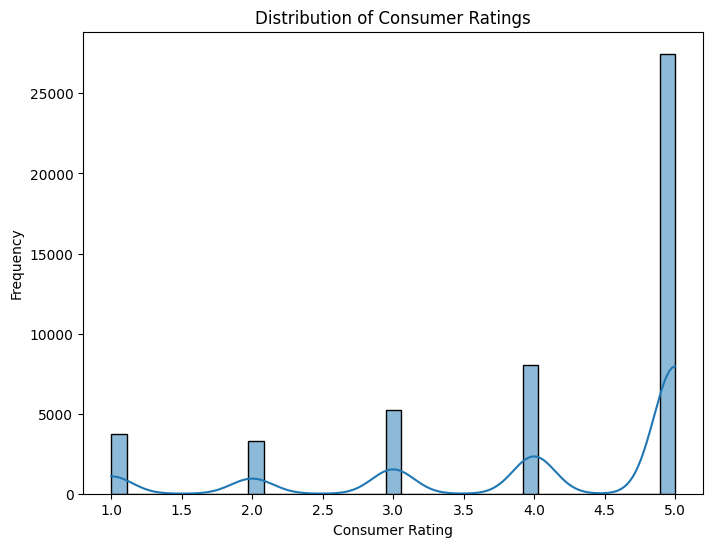

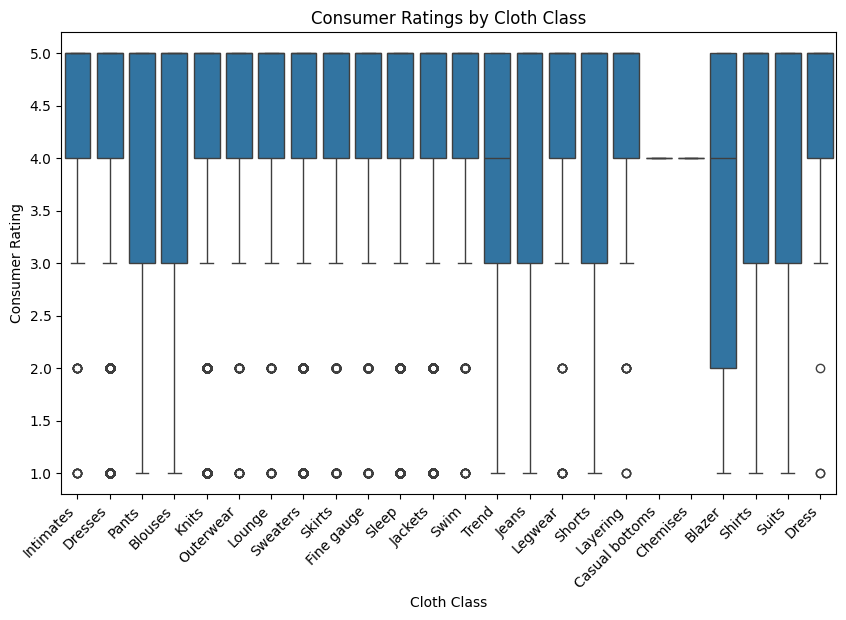

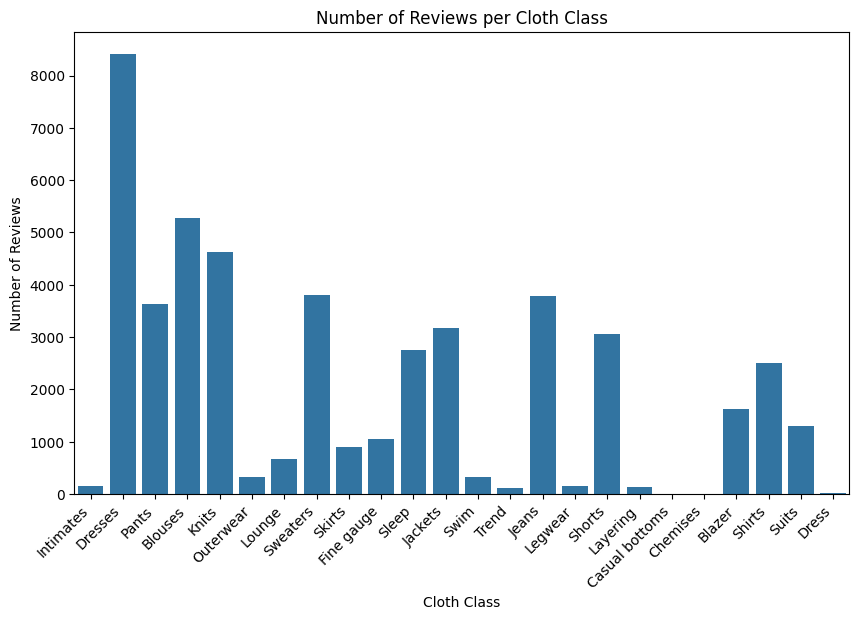

In [34]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Cons_rating'], kde=True)
plt.title('Distribution of Consumer Ratings')
plt.xlabel('Consumer Rating')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cloth_class', y='Cons_rating', data=df)
plt.title('Consumer Ratings by Cloth Class')
plt.xlabel('Cloth Class')
plt.ylabel('Consumer Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Cloth_class', data=df)
plt.title('Number of Reviews per Cloth Class')
plt.xlabel('Cloth Class')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

In [35]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

minority_df = df[df['Cons_rating'].isin([1.0, 2.0])]

syn_aug = naw.SynonymAug(aug_src='wordnet')

augmented_reviews = []
augmented_ratings = []
augmented_classes = []

for idx, row in minority_df.iterrows():
    for _ in range(2):
        try:
            new_review = syn_aug.augment(row['Review'])
            augmented_reviews.append(new_review)
            augmented_ratings.append(row['Cons_rating'])
            augmented_classes.append(row['Cloth_class'])
        except Exception as e:
            print(f"Gagal augmentasi: {e}")
            continue

aug_df = pd.DataFrame({
    'Review': augmented_reviews,
    'Cons_rating': augmented_ratings,
    'Cloth_class': augmented_classes
})

df_balanced = pd.concat([df, aug_df], ignore_index=True)

df_balanced['Review'] = df_balanced['Review'].astype(str)

print("\nDistribusi setelah balancing:")
print(df_balanced['Cons_rating'].value_counts())

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Distribusi setelah balancing:
Cons_rating
5.0    27475
1.0    11244
2.0     9783
4.0     8056
3.0     5255
Name: count, dtype: int64


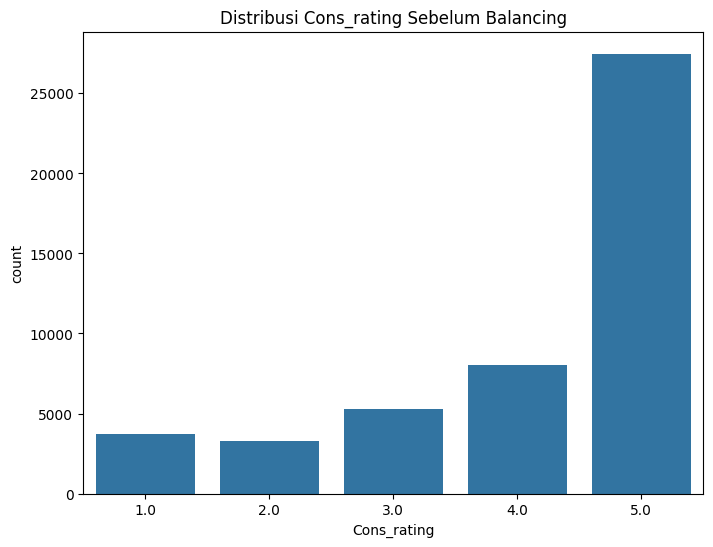

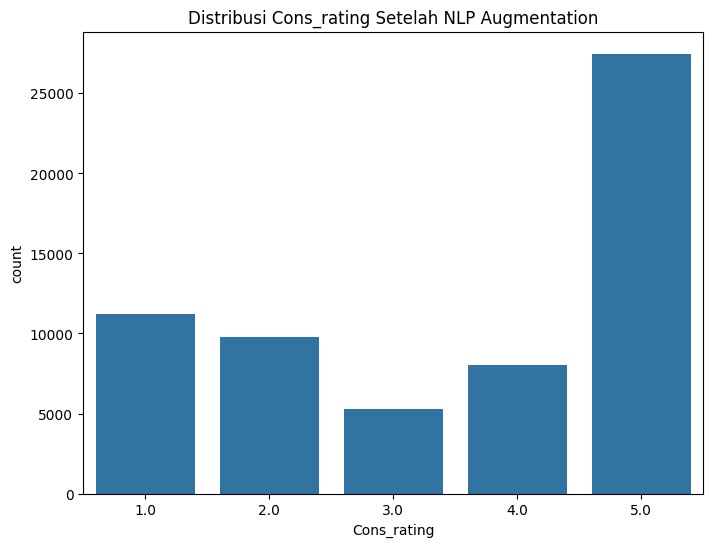

In [36]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Cons_rating', data=df)
plt.title('Distribusi Cons_rating Sebelum Balancing')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Cons_rating', data=df_balanced)
plt.title('Distribusi Cons_rating Setelah NLP Augmentation')
plt.show()

# Data Splitting

In [37]:
X = df_balanced['Review']
y = df_balanced['Cons_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling

In [38]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('ridge', Ridge())
])

param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__min_df': [2, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'ridge__alpha': [0.1, 1.0, 10.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1.0, 10.0],
                         'tfidf__max_df': [0.8, 0.9, 1.0],
                         'tfidf__min_df': [2, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

# Model Evaluation

In [39]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_pred = np.clip(y_pred, 1, 5)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("🔍 Best Parameters:", grid.best_params_)
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

🔍 Best Parameters: {'ridge__alpha': 1.0, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
MAE: 0.596
RMSE: 0.803
R² Score: 0.749


# Save Best Model

In [40]:
joblib.dump(best_model, 'sentimentModel.pkl')

['sentimentModel.pkl']

# Model Test

In [41]:
user_input = ["I LOVE THIS SHIRT"]
predicted_rating = best_model.predict(user_input)[0]
predicted_rating = np.clip(predicted_rating, 1, 5)
print(f"Predicted Rating: {predicted_rating:.2f}")

Predicted Rating: 4.95
